In [2]:
# IMPORT NEEDED LIBRARIES 
import pandas as pd
import numpy as np
import warnings
import pmdarima as pm 
import math
from pmdarima import auto_arima
import matplotlib.pyplot as plt 
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from common.preprocessor import load_data
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
%matplotlib inline
pd.options.display.float_format = '{:,.2f}'.format
np.set_printoptions(precision=2)
warnings.filterwarnings("ignore")

In [3]:
# load data from the preprocessor and set index to date column
data = pd.read_csv('Modified Data.csv', parse_dates=True, index_col=[0])

In [4]:
data.head() # display the first 5 rows of the data

,Price
2002-01-01,19.96
2002-02-01,20.19
2002-03-01,24.03
2002-04-01,26.03
2002-05-01,25.69


In [5]:
data.describe() # display the summary statistics of the data

,Price
count,252.00
mean,69.46
std,28.03
min,19.96
25%,48.47
50%,65.47
75%,91.95
max,134.79


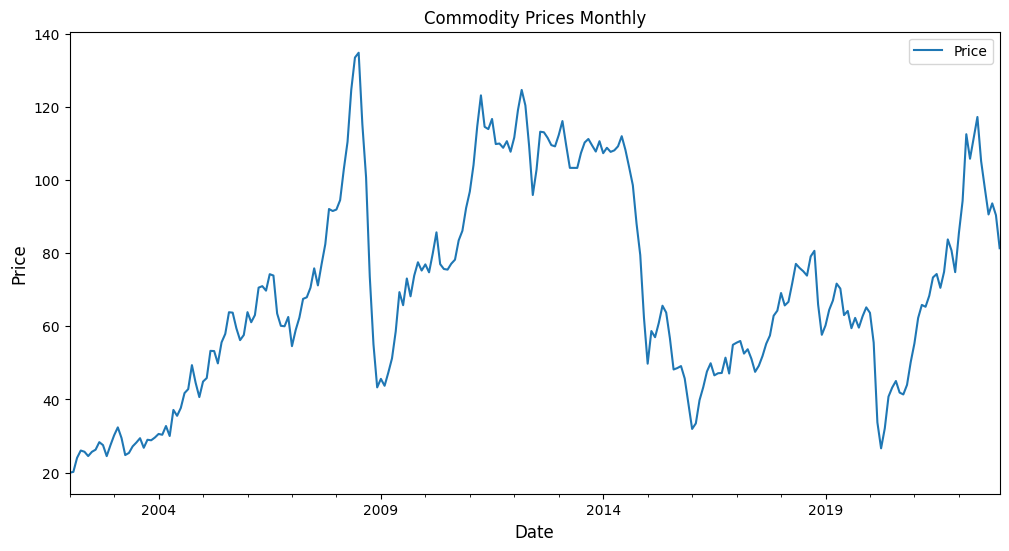

In [6]:
# visualize the data
data.plot(y='Price', title='Commodity Prices Monthly', figsize=(12, 6))
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price', fontsize=12)
plt.show()

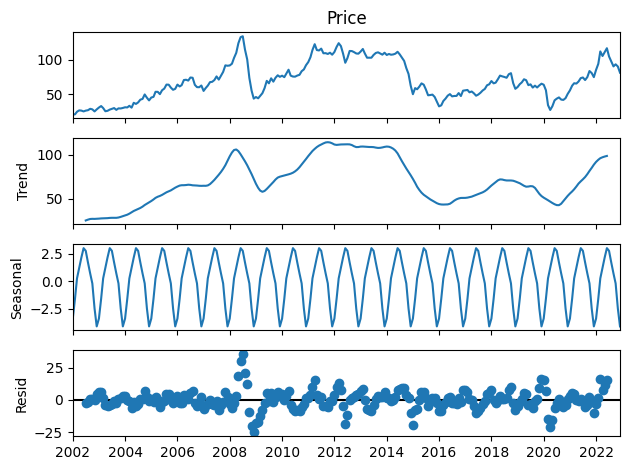

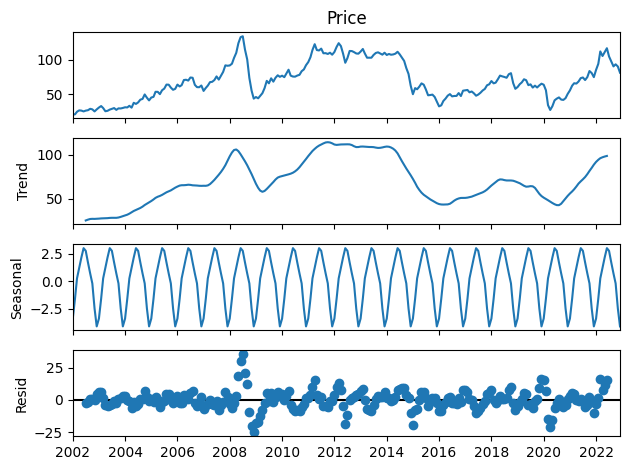

In [7]:
# visualize the components of the data
decomposition = seasonal_decompose(data["Price"], model="additive")  # "Price" is likely your column name for oil prices
decomposition.plot()  # Visualize the trend, seasonal component, and residuals

In [8]:
# set the train and test data with start dates
train_start_date = '2002-01-01'
test_start_date = '2019-01-01'

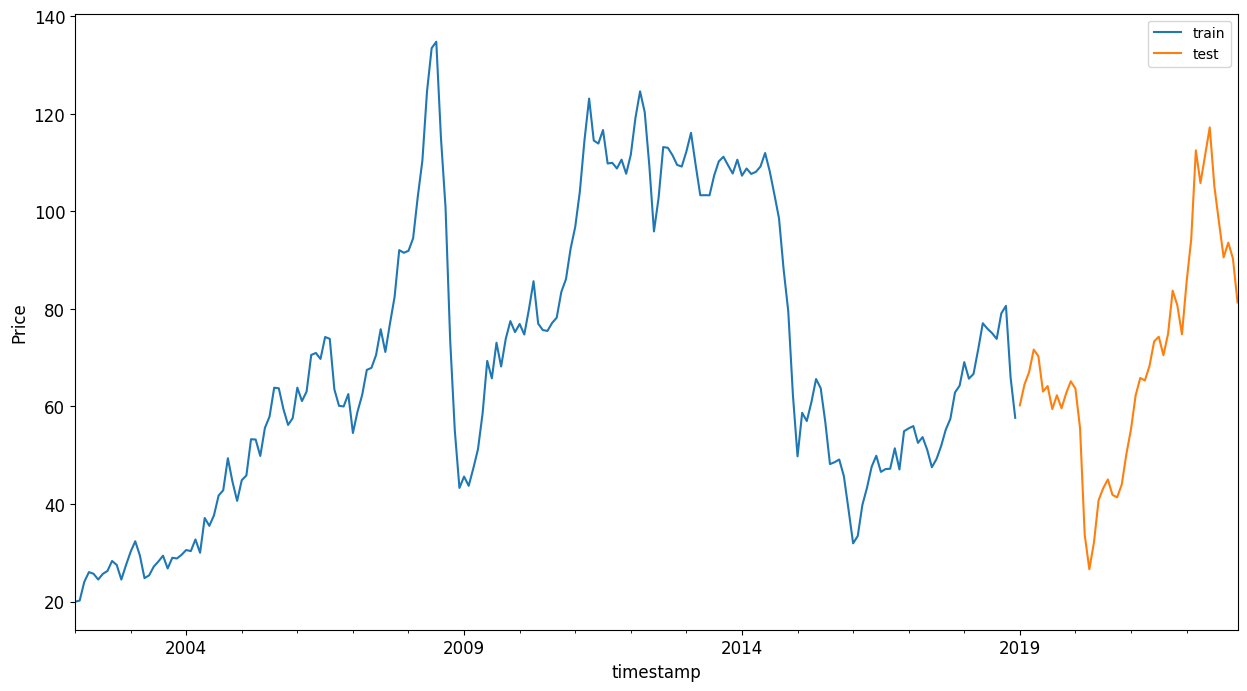

In [9]:
# visualize the train and test data
data[(data.index < test_start_date) & (data.index >= train_start_date)][['Price']].rename(columns={'Price':'train'}) \
    .join(data[test_start_date:][['Price']].rename(columns={'Price':'test'}), how='outer') \
    .plot(y=['train', 'test'], figsize=(15, 8), fontsize=12)
plt.xlabel('timestamp', fontsize=12)
plt.ylabel('Price', fontsize=12)
plt.show()

In [10]:
# set the train and test data and print the dimensions of it
train = data.copy()[(data.index >= train_start_date) & (data.index < test_start_date)][['Price']]
test = data.copy()[data.index >= test_start_date][['Price']]

print('Training data shape: ', train.shape)
print('Test data shape: ', test.shape)

Training data shape:  (204, 1)
Test data shape:  (48, 1)


In [11]:
train

,Price
2002-01-01,19.96
2002-02-01,20.19
2002-03-01,24.03
2002-04-01,26.03
2002-05-01,25.69
...,...
2018-08-01,73.85
2018-09-01,79.09
2018-10-01,80.63
2018-11-01,65.96


In [12]:
test

,Price
2019-01-01,60.23
2019-02-01,64.50
2019-03-01,67.05
2019-04-01,71.66
2019-05-01,70.30
2019-06-01,63.05
2019-07-01,64.19
2019-08-01,59.47
2019-09-01,62.29
2019-10-01,59.63


In [13]:
# Check for stationarity with ADF test
def adf_test(series):
    result = adfuller(series, autolag='AIC')
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    if result[1] <= 0.05:
        print("Data is likely stationary.")
    else:
        print("Data may be non-stationary. Consider differencing.")

print("Testing stationarity of scaled training data:")
adf_test(train['Price'])

Testing stationarity of scaled training data:
ADF Statistic: -2.5026745232331122
p-value: 0.11482493982756942
Data may be non-stationary. Consider differencing.


In [14]:
# Identify number of differences required (if necessary)
n_diffs = pm.arima.ndiffs(train['Price'], test='adf')
print(f"\nNumber of differences required for scaled training data: {n_diffs}")



Number of differences required for scaled training data: 1


In [15]:
# Perform differencing if required
if n_diffs > 0:
    differenced_train = train.diff(n_diffs).dropna()
else:
    differenced_train = train.copy()

<Axes: >

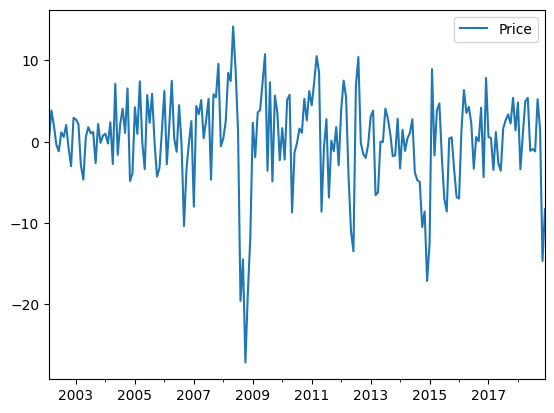

In [16]:
# plot differenced data
differenced_train.plot()

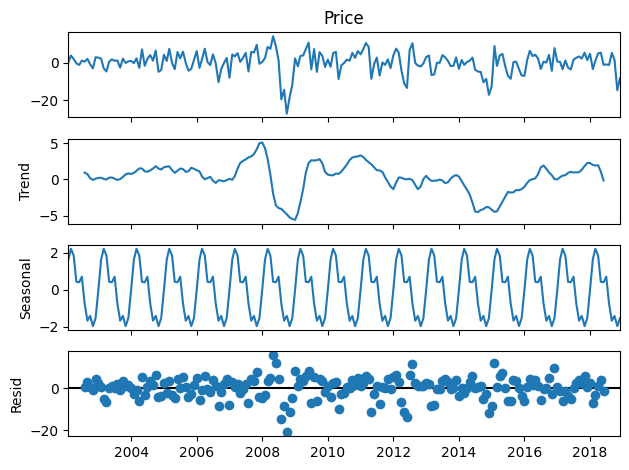

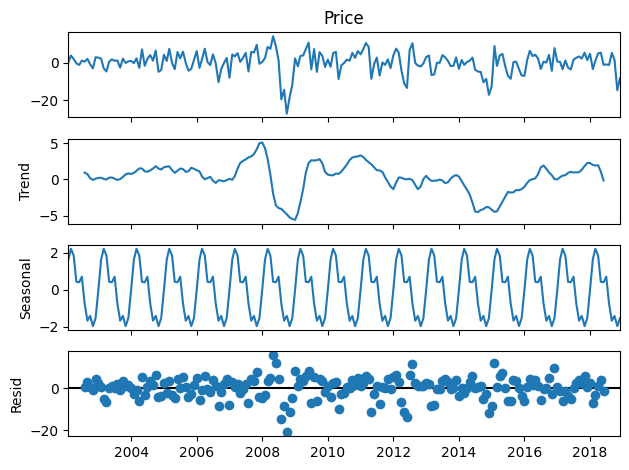

In [17]:
# visualize the components of the differenced data
decomposition = seasonal_decompose(differenced_train["Price"], model="additive")  # "Price" is likely your column name for oil prices
decomposition.plot()  # Visualize the trend, seasonal component, and residuals


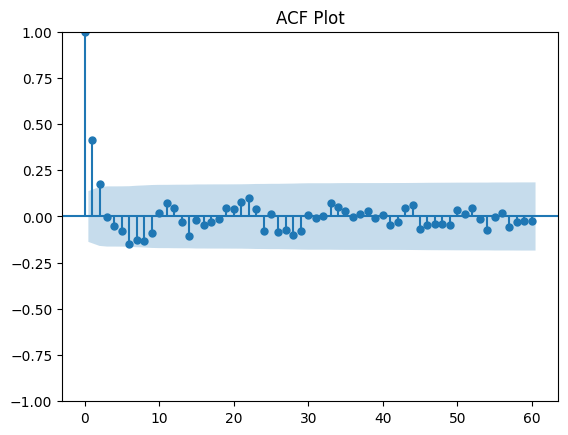

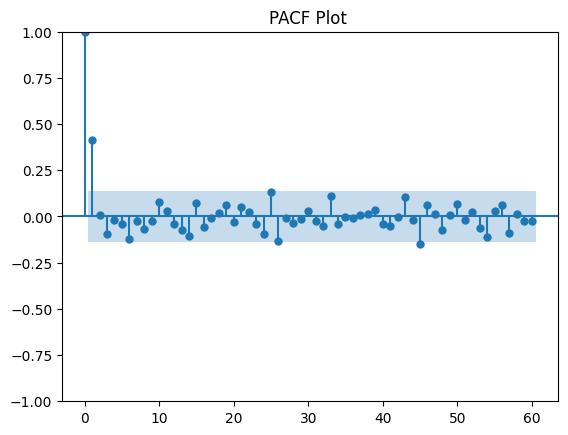

In [18]:
# ACF and PACF plots (optional) using lags of 60 (5 years)
plot_acf(differenced_train['Price'], lags=60, title='ACF Plot')
plt.show()
plot_pacf(differenced_train['Price'], lags=60, title='PACF Plot ')
plt.show()

In [19]:


df_2002 = data['2002']
df_2003 = data['2003']
df_2004 = data['2004']
df_2005 = data['2005']
df_2006 = data['2006']
df_2007 = data['2007']
# Create subplot figure
fig = make_subplots(rows=6, cols=1)

# Add traces
fig.add_trace(go.Scatter(x=df_2002.index, y=df_2002['Price'], name='Price in 2002'), row=1, col=1)
fig.add_trace(go.Scatter(x=df_2003.index, y=df_2003['Price'], name='Price in 2003'), row=2, col=1)
fig.add_trace(go.Scatter(x=df_2004.index, y=df_2004['Price'], name='Price in 2004'), row=3, col=1)
fig.add_trace(go.Scatter(x=df_2005.index, y=df_2005['Price'], name='Price in 2005'), row=4, col=1)
fig.add_trace(go.Scatter(x=df_2006.index, y=df_2006['Price'], name='Price in 2006'), row=5, col=1)
fig.add_trace(go.Scatter(x=df_2007.index, y=df_2007['Price'], name='Price in 2007'), row=6, col=1)


# Update xaxis properties
fig.update_xaxes(title_text="Date", row=1, col=1)
fig.update_xaxes(title_text="Date", row=2, col=1)
fig.update_xaxes(title_text="Date", row=3, col=1)
fig.update_xaxes(title_text="Date", row=4, col=1)
fig.update_xaxes(title_text="Date", row=5, col=1)
fig.update_xaxes(title_text="Date", row=6, col=1)




# Update yaxis properties
fig.update_yaxes(title_text="Price", row=1, col=1)
fig.update_yaxes(title_text="Price", row=2, col=1)
fig.update_yaxes(title_text="Price", row=3, col=1)
fig.update_yaxes(title_text="Price", row=4, col=1)
fig.update_yaxes(title_text="Price", row=5, col=1)
fig.update_yaxes(title_text="Price", row=6, col=1)


# Update layout
fig.update_layout(height=1000, width=1200, title_text="Price from 2002 to 2007")

fig.show()

In [20]:
# Check for stationarity on differenced data with ADF test
def adf_test(series):
    result = adfuller(series, autolag='AIC')
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    if result[1] <= 0.05:
        print("Data is likely stationary.")
    else:
        print("Data may be non-stationary. Consider differencing.")

print("Testing stationarity of scaled training data:")
adf_test(differenced_train['Price'])

Testing stationarity of scaled training data:
ADF Statistic: -9.015794676260294
p-value: 5.9556970044840115e-15
Data is likely stationary.


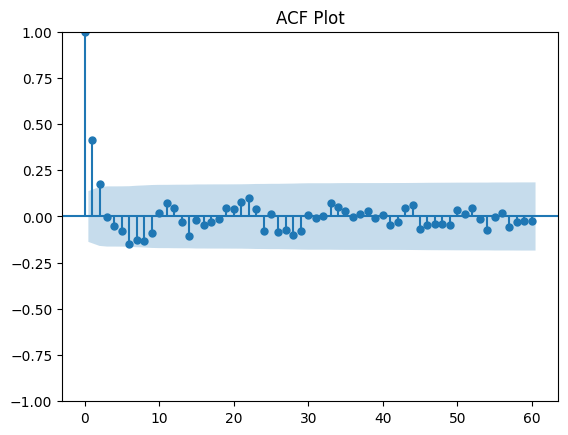

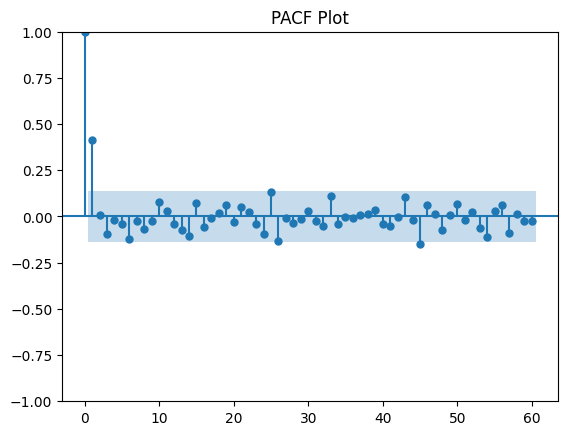

In [21]:
# ACF and PACF plots on differenced data
plot_acf(differenced_train['Price'], lags=60, title='ACF Plot')
plt.show()
plot_pacf(differenced_train['Price'], lags=60, title='PACF Plot')
plt.show()

In [22]:
# Use auto_arima to find best parameters
model = auto_arima(differenced_train['Price'], start_p=1, start_q=1, max_p=3, max_q=3, m=12,
                  start_P=0, seasonal=True, d=None, max_d=2, D=1, max_D=2, trace=True,
                  error_action='ignore', suppress_warnings=True,
                  stepwise=True)
print(f"\nAuto ARIMA identified parameters: {model.order}, {model.seasonal_order}")
# decide tradeoff between time and aic

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=0.99 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=1342.381, Time=0.04 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=1281.283, Time=0.41 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=1.33 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=1340.404, Time=0.05 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=1308.779, Time=0.10 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=1255.622, Time=1.87 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=3.63 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=1.22 sec
 ARIMA(0,0,0)(2,1,0)[12] intercept   : AIC=1288.130, Time=1.41 sec
 ARIMA(2,0,0)(2,1,0)[12] intercept   : AIC=1257.341, Time=1.99 sec
 ARIMA(1,0,1)(2,1,0)[12] intercept   : AIC=1257.435, Time=2.31 sec
 ARIMA(0,0,1)(2,1,0)[12] intercept   : AIC=1263.110, Time=1.72 sec
 ARIMA(2,0,1)(2,1,0)[12] intercept   : AIC=1258.579, Time=3.41 sec
 ARIMA(1,0,0)(2,1,0)[12]             : 

In [23]:
# other information criteria
model = auto_arima(differenced_train['Price'], start_p=1, start_q=1, max_p=3, max_q=3, m=12,
                  start_P=0, seasonal=True, d=None, max_d=2, D=1, max_D=2, trace=True,
                  error_action='ignore', suppress_warnings=True,
                  stepwise=True, information_criterion='bic')
print(f"\nAuto ARIMA identified parameters: {model.order}, {model.seasonal_order}")
# decide tradeoff between time and aic

Performing stepwise search to minimize bic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : BIC=inf, Time=1.00 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : BIC=1348.885, Time=0.05 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : BIC=1294.292, Time=0.42 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : BIC=inf, Time=1.24 sec
 ARIMA(0,0,0)(0,1,0)[12]             : BIC=1343.656, Time=0.04 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : BIC=1318.536, Time=0.09 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : BIC=1271.883, Time=1.82 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : BIC=inf, Time=3.09 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : BIC=inf, Time=0.95 sec
 ARIMA(0,0,0)(2,1,0)[12] intercept   : BIC=1301.140, Time=1.32 sec
 ARIMA(2,0,0)(2,1,0)[12] intercept   : BIC=1276.854, Time=1.90 sec
 ARIMA(1,0,1)(2,1,0)[12] intercept   : BIC=1276.949, Time=2.28 sec
 ARIMA(0,0,1)(2,1,0)[12] intercept   : BIC=1279.372, Time=1.78 sec
 ARIMA(2,0,1)(2,1,0)[12] intercept   : BIC=1281.345, Time=3.12 sec
 ARIMA(1,0,0)(2,1,0)[12]             : 

In [24]:
# other information criteria
model = auto_arima(differenced_train['Price'], start_p=1, start_q=1, max_p=3, max_q=3, m=12,
                  start_P=0, seasonal=True, d=None, max_d=2, D=1, max_D=2, trace=True,
                  error_action='ignore', suppress_warnings=True,
                  stepwise=True, information_criterion='hqic')
print(f"\nAuto ARIMA identified parameters: {model.order}, {model.seasonal_order}")
# decide tradeoff between time and aic

Performing stepwise search to minimize hqic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : HQIC=inf, Time=1.03 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : HQIC=1345.015, Time=0.03 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : HQIC=1286.552, Time=0.30 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : HQIC=inf, Time=1.12 sec
 ARIMA(0,0,0)(0,1,0)[12]             : HQIC=1341.721, Time=0.05 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : HQIC=1312.731, Time=0.10 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : HQIC=1262.208, Time=1.64 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : HQIC=inf, Time=3.29 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : HQIC=inf, Time=0.93 sec
 ARIMA(0,0,0)(2,1,0)[12] intercept   : HQIC=1293.400, Time=1.30 sec
 ARIMA(2,0,0)(2,1,0)[12] intercept   : HQIC=1265.244, Time=1.83 sec
 ARIMA(1,0,1)(2,1,0)[12] intercept   : HQIC=1265.339, Time=2.43 sec
 ARIMA(0,0,1)(2,1,0)[12] intercept   : HQIC=1269.697, Time=1.96 sec
 ARIMA(2,0,1)(2,1,0)[12] intercept   : HQIC=1267.800, Time=3.29 sec
 ARIMA(1,0,0)(2,1,0)[12]

In [25]:
print(f'model order: {model.order}, \nmodel seasonal order: {model.seasonal_order}')

model order: (1, 0, 0), 
model seasonal order: (2, 1, 0, 12)


In [26]:
# Fit the SARIMA model on the differenced training data
model = SARIMAX(endog=differenced_train, order=model.order, seasonal_order=model.seasonal_order, freq="MS")
results = model.fit(disp=0)  # Suppress convergence output
print(results.summary())

                                     SARIMAX Results                                      
Dep. Variable:                              Price   No. Observations:                  203
Model:             SARIMAX(1, 0, 0)x(2, 1, 0, 12)   Log Likelihood                -622.817
Date:                            Tue, 26 Mar 2024   AIC                           1253.635
Time:                                    15:39:28   BIC                           1266.644
Sample:                                02-01-2002   HQIC                          1258.904
                                     - 12-01-2018                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4100      0.056      7.335      0.000       0.300       0.520
ar.S.L12      -0.5252      0.058   

In [31]:
train.shape

(204, 1)

In [30]:
test.shape

(48, 1)

In [32]:
HORIZON = 3
test_shifted = test.copy()

for t in range(1, HORIZON):
    test_shifted['Price+'+str(t)] = test_shifted['Price'].shift(-t, freq='MS')

test_shifted = test_shifted.dropna(how='any')
test_shifted.head(5)

,Price,Price+1,Price+2
2019-01-01,60.23,64.50,67.05
2019-02-01,64.50,67.05,71.66
2019-03-01,67.05,71.66,70.30
2019-04-01,71.66,70.30,63.05
2019-05-01,70.30,63.05,64.19


In [33]:
model.order

(1, 0, 0)

In [34]:
model.seasonal_order

(2, 1, 0, 12)

In [35]:
%%time
training_window = 40
# dedicate 24 months (2 years) for training

train_ts = train['Price']
test_ts = test_shifted

history = [x for x in train_ts]
history = history[(-training_window):]

predictions = list()

order = model.order
seasonal_order = model.seasonal_order

for t in range(test_ts.shape[0]):
    model = SARIMAX(endog=history, order=order, seasonal_order=seasonal_order)
    model_fit = model.fit()
    yhat = model_fit.forecast(steps = HORIZON)
    predictions.append(yhat)
    obs = list(test_ts.iloc[t])
    # move the training window
    history.append(obs[0])
    history.pop(0)
    print(test_ts.index[t])
    print(t+1, ': predicted =', yhat, 'expected =', obs)


2019-01-01 00:00:00
1 : predicted = [53.01 53.93 56.39] expected = [60.23, 64.5, 67.05]
2019-02-01 00:00:00
2 : predicted = [59.66 60.95 63.64] expected = [64.5, 67.05, 71.66]
2019-03-01 00:00:00
3 : predicted = [67.52 70.47 73.45] expected = [67.05, 71.66, 70.3]
2019-04-01 00:00:00
4 : predicted = [70.14 73.12 72.67] expected = [71.66, 70.3, 63.05]
2019-05-01 00:00:00
5 : predicted = [73.49 74.64 72.26] expected = [70.3, 63.05, 64.19]
2019-06-01 00:00:00
6 : predicted = [71.07 69.03 70.98] expected = [63.05, 64.19, 59.47]
2019-07-01 00:00:00
7 : predicted = [67.21 68.38 76.96] expected = [64.19, 59.47, 62.29]
2019-08-01 00:00:00
8 : predicted = [65.61 74.21 74.52] expected = [59.47, 62.29, 59.63]
2019-09-01 00:00:00
9 : predicted = [67.28 68.62 64.52] expected = [62.29, 59.63, 62.71]
2019-10-01 00:00:00
10 : predicted = [65.51 53.93 55.98] expected = [59.63, 62.71, 65.17]
2019-11-01 00:00:00
11 : predicted = [48.31 50.22 51.07] expected = [62.71, 65.17, 63.67]
2019-12-01 00:00:00
12 :

In [36]:
eval_df = pd.DataFrame(predictions, columns=['m+'+str(t) for t in range(1, HORIZON+1)])
eval_df['timestamp'] = test.index[0:len(test.index)-HORIZON+1]
eval_df = pd.melt(eval_df, id_vars='timestamp', value_name='prediction', var_name='month')
eval_df['actual'] = np.array(np.transpose(test_ts)).ravel()
# eval_df[['prediction', 'actual']] = scaler.inverse_transform(eval_df[['prediction', 'actual']])



,timestamp,month,prediction,actual
0,2019-01-01,m+1,53.01,60.23
1,2019-02-01,m+1,59.66,64.50
2,2019-03-01,m+1,67.52,67.05
3,2019-04-01,m+1,70.14,71.66
4,2019-05-01,m+1,73.49,70.30


In [38]:
eval_df.to_csv("predicted vs actual.csv")

In [39]:
# print one step forecast MAPE
print(f'''
    One Step forecast MAPE: 
    {mean_absolute_percentage_error(eval_df[eval_df['month'] == 'm+1']['prediction'], eval_df[eval_df['month'] == 'm+1']['actual'])}''')



    One Step forecast MAPE: 
    0.1013595186375522


In [40]:
# print multistep mape
print(f'''
    Multi-Step forecast MAPE: 
    {mean_absolute_percentage_error(eval_df['prediction'], eval_df['actual'])}''')


    Multi-Step forecast MAPE: 
    0.16076040439312586


In [43]:
data.describe()

,Price
count,252.00
mean,69.46
std,28.03
min,19.96
25%,48.47
50%,65.47
75%,91.95
max,134.79


In [41]:
mean_squared_error(eval_df['prediction'], eval_df['actual'])

178.57767225010184

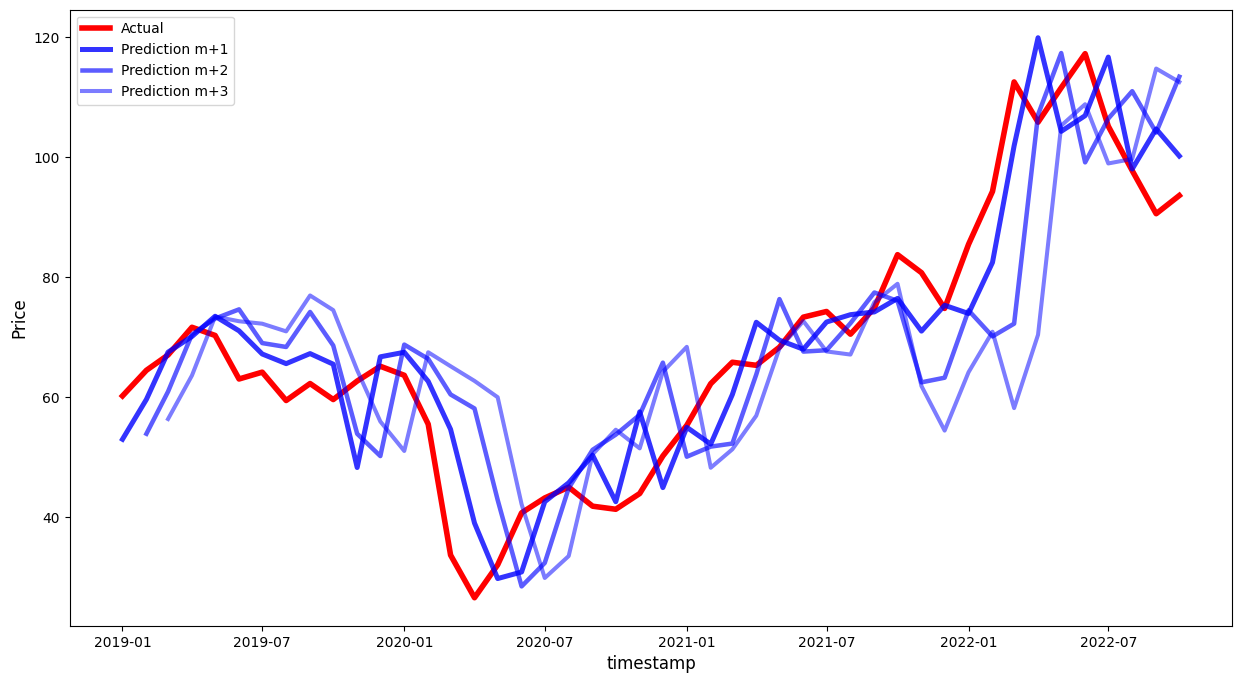

In [44]:
# plot of actual vs predicted
if(HORIZON == 1):
    ## Plotting single step forecast
    eval_df.plot(x='timestamp', y=['actual', 'prediction'], style=['r', 'b'], figsize=(15, 8))

else:
    ## Plotting multi step forecast
    plot = eval_df[(eval_df.month=='m+1')][['timestamp', 'actual']]
    for m in range(1, HORIZON+1):
        plot['m+'+str(m)] = eval_df[(eval_df.month=='m+'+str(m))]['prediction'].values

    fig = plt.figure(figsize=(15, 8))
    plt.plot(plot['timestamp'], plot['actual'], color='red', linewidth=4.0, label='Actual')  # Add label here
    for m in range(1, HORIZON+1):
        x = plot['timestamp'][(m-1):]
        y = plot['m+'+str(m)][0:len(x)]
        plt.plot(x, y, color='blue', linewidth=4*math.pow(.9,m), alpha=math.pow(0.8,m), label='Prediction m+'+str(m))  # Add label here
    
plt.xlabel('timestamp', fontsize=12)
plt.ylabel('Price', fontsize=12)
plt.legend()  # Add this line to display the legend
plt.show()

In [45]:
import plotly.graph_objects as go

# Create a new figure
fig = go.Figure()

if(HORIZON == 1):
    ## Plotting single step forecast
    fig.add_trace(go.Scatter(x=eval_df['timestamp'], y=eval_df['actual'], mode='lines', name='Actual'))
    fig.add_trace(go.Scatter(x=eval_df['timestamp'], y=eval_df['prediction'], mode='lines', name='Prediction'))

else:
    ## Plotting multi step forecast
    plot = eval_df[(eval_df.month=='m+1')][['timestamp', 'actual']]
    for m in range(1, HORIZON+1):
        plot['m+'+str(m)] = eval_df[(eval_df.month=='m+'+str(m))]['prediction'].values

    fig.add_trace(go.Scatter(x=plot['timestamp'], y=plot['actual'], mode='lines', name='Actual'))
    for m in range(1, HORIZON+1):
        x = plot['timestamp'][(m-1):]
        y = plot['m+'+str(m)][0:len(x)]
        fig.add_trace(go.Scatter(x=x, y=y, mode='lines', name='Prediction m+'+str(m)))

# Set the title and labels
fig.update_layout(title='Actual vs Predicted', xaxis_title='Timestamp', yaxis_title='Price', height=1000, width=1000)


# Show the figure
fig.show()